## Aplicando *Multilayer Perceptron*

Está demonstrado neste ponto a execução de um Multilayer Perceptron (MLP) utilizando o framework para construção e execução de Redes Neurais Artificias (RNN) Keras.

Vamos iniciar mostrando como carregar uma base de dados da UCI e utilizar o classificador ID3 obtido por meio scikit learn. A base de dados é a Car Evaluation Data Set (https://archive.ics.uci.edu/ml/datasets/Car+Evaluation).

O dataset possui os seguintes atributos:

- buying: vhigh, high, med, low.
- maint: vhigh, high, med, low.
- doors: 2, 3, 4, 5more.
- persons: 2, 4, more.
- lug_boot: small, med, big.
- safety: low, med, high.
E as seguintes classes: unacc, acc, good, vgood

### Definição de todas as bibliotecas

In [1]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from urllib.request import urlopen, urlretrieve

import matplotlib.pyplot as plt
%matplotlib inline

2022-06-01 22:33:49.435899: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-01 22:33:49.439187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 22:33:49.439201: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Código para o carregamento da base de dados

Após o carregamento dos dados, é utilizado a função LabelEncoder para transformar os dados de categóricos para numéricos.

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
urlretrieve(url, 'car.txt')
filedata = open('car.txt')
data = filedata.read()
dataset = np.array([s.split(',') for s in data.split('\n')][:-1])
print(dataset)
print(len(dataset))
print(dataset.shape)

# Transformação dos valores de categórico para numérico
le = LabelEncoder()
features = np.array([le.fit_transform(f) for f in dataset[:, :-1].T]).T

# obtendo a coluna com as respostas
labels = le.fit_transform(dataset[:, -1])
categorical_labels = to_categorical(labels, num_classes=len(set(labels)))

[['vhigh' 'vhigh' '2' ... 'small' 'low' 'unacc']
 ['vhigh' 'vhigh' '2' ... 'small' 'med' 'unacc']
 ['vhigh' 'vhigh' '2' ... 'small' 'high' 'unacc']
 ...
 ['low' 'low' '5more' ... 'big' 'low' 'unacc']
 ['low' 'low' '5more' ... 'big' 'med' 'good']
 ['low' 'low' '5more' ... 'big' 'high' 'vgood']]
1728
(1728, 7)


In [3]:
categorical_labels

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [8]:
categorical_labels.shape

(1728, 4)

### Desenvolvimento da função para plotar os custos e as acurácias:

In [4]:
def plot_history(h):
    loss_list = [s for s in h.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in h.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in h.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in h.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Custo não está presente no histórico')
        return
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    # Custo
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, h.history[l], 'b',
                 label='Custo [treinamento] (' + str(str(format(
                    h.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, h.history[l], 'g',
                 label='Custo [validação] (' + str(str(format(
                    h.history[l][-1],'.5f'))+')'))
    plt.title('Custo')
    plt.xlabel('Épocas')
    plt.ylabel('Custo')
    plt.legend()
    # Acurácia
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, h.history[l], 'b',
                 label='Acurácia [treinamento] (' + str(format(
                    h.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, h.history[l], 'g',
                 label='Acurácia [validação] (' + str(format(
                    h.history[l][-1],'.5f'))+')')
    plt.title('Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()

In [5]:
# plot_history(features)

### Divisão dos dados em treino e teste:

In [6]:
# Dividindo em conjuntos de treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    features, categorical_labels, test_size=0.3)

# treino: 80% dos 80% de treino. teste: 20% dos 80% de treino.
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, shuffle=True)

In [7]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((846, 6), (363, 6), (846, 4), (363, 4))

### Aplicação do algoritmo de MLP e geração dos resultados:

Epoch 1/150


2022-05-31 15:22:03.345325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-31 15:22:03.345340: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-31 15:22:03.345354: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luisotavio-Aspire5): /proc/driver/nvidia/version does not exist
2022-05-31 15:22:03.345512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/luisotavio/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gr

57/57 [==============================] - 1s 3ms/step - loss: 1.0483 - accuracy: 0.6832 - val_loss: 0.8737 - val_accuracy: 0.7273
Epoch 2/150
57/57 [==============================] - 0s 2ms/step - loss: 0.8439 - accuracy: 0.7092 - val_loss: 0.7820 - val_accuracy: 0.7328
Epoch 3/150
57/57 [==============================] - 0s 3ms/step - loss: 0.7856 - accuracy: 0.7139 - val_loss: 0.7395 - val_accuracy: 0.7383
Epoch 4/150
57/57 [==============================] - 0s 3ms/step - loss: 0.7328 - accuracy: 0.7400 - val_loss: 0.6933 - val_accuracy: 0.7521
Epoch 5/150
57/57 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.7482 - val_loss: 0.6729 - val_accuracy: 0.7686
Epoch 6/150
57/57 [==============================] - 0s 2ms/step - loss: 0.6602 - accuracy: 0.7719 - val_loss: 0.6225 - val_accuracy: 0.7989
Epoch 7/150
57/57 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.7790 - val_loss: 0.5884 - val_accuracy: 0.7961
Epoch 8/150
57/57 [======

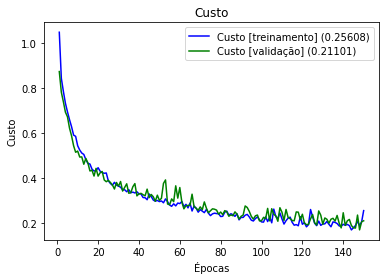

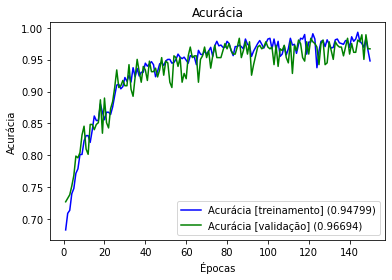

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [11]:
# definição de uma fração do regularizador
l = 0.01

# desenvolvimento do modelo Keras para uma MLP
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=6,
                kernel_regularizer=regularizers.l2(l)))
# Aplicação de um dropout (caso necessário)
# model.add(Dropout(0.5))
model.add(Dense(10, activation='relu',
                kernel_regularizer=regularizers.l2(l)))
# Aplicação de um dropout (caso necessário)
# model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Aplicação de um modelo de descida de gradiente utilizando o Stocastic Gradient Descendent (SGD)
sgd = SGD(lr=0.05, momentum=0.0)
# Função de otimização da rede: ADAM
adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999)
# Função de custo baseada em dados originalmente categóricos
model.compile(loss='categorical_crossentropy', optimizer=adam,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, batch_size=15,
                    validation_data=(X_val, y_val))
plot_history(history)
score = model.predict_classes(X_test)
y_true = [np.where(x == 1)[0][0] for x in y_test]
print('Acurácia: %0.2f%%' % (accuracy_score(y_true, score) * 100))
print('Matriz de confusão:')
print(confusion_matrix(y_true, score))
print()
print(classification_report(y_true, score, digits=5))

**Desafio:** "Encaixar" o classificador MLP no no *dataset* criado durante a disciplina.